# Title of Your Group Project

This Python notebook serves as a template for your group project on Experiment 1: Two-Armed Bandit Tasks for the course 'Modeling in Cognitive Science'.
This is the practical part of the group project where you get to implement the computational modeling workflow. In this part, you are expected to:


*   Implement at least two computational models relevant for your hypothesis. *(3 points)*
*   Simulate behavior from the two models. *(3 points)*
*   Implement a procedure for fitting the models to data. *(4 points)*
*   Implement a procedure for parameter recovery. *(5 points)*
*   (Implement a procedure for model recovery.) *(optional; 2 bonus points)*
*   Implement a model comparison. *(5 points)*.

You can gain a total of 20 points for the practical part of the group project.

**Note:** *Some of the exercises below (e.g. Model Simulation) rely on code from previous exercises (e.g., Model Implementation). In such cases, you are encouraged to rely on functions implemented for previous exercises. That is, you don't have to produce redundant code.*

For more information, you can check the task's GitHub repository:
[2 armed bandit task](https://github.com/snamazova/two_armed_bandit_task)



## Data Loading


In [114]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random
import seaborn as sns


# experiment constants
num_arms = 2
probs = [0.8, 0.2]
trial_probaility_change = (
    50  # number of trials to change the probability of the chosen option
)
total_trials = 100  # total number of trials

In [115]:
df = pd.read_json("2armed_bandit.json")

### DataFrame Structure Overview

The DataFrame(df) contains multiple columns representing various aspects of a **two-armed bandit experiment**. Below is a breakdown of the key columns:  

## 1. General Trial Information  
- **`trial_index`**: The index of the current trial in the experiment (note: displaying the score is also considered a trial, as it is a stimulus).  
- **`trial_type`**: The type of trial, indicating how the response was made (e.g., via keyboard or mouse click).  
- **`time_elapsed`**: The total time elapsed (in milliseconds) since the start of the experiment.  
- **`internal_node_id`**: An internal identifier for the trial structure.  

## 2. Response and Stimulus Data  
- **`stimulus`**: The presented stimulus for the trial (a `<div>` tag containing the value and color of the bandit).  
- **`response`**: The participant’s response/input during the trial.  
- **`rt`**: The reaction time (in milliseconds) taken to respond.  

## 3. Task-Specific Information (Bean Task)    
- **`bean_trial_duration`**: The duration of the bean trial.  
- **`bean_duration`**: The time the bean stimulus was displayed.  
- **`bean_stimulus`**: The presented stimulus for the trial (a `<div>` tag containing the value and color of the bandit).  
- **`bean_choices`**: The available choice options in the trial.  
- **`bean_correct_key`**: The correct key (button press) for the task.  
- **`bean_type`**: The category of the bean stimulus.  
- **`bean_text`**: A text representation of the bean (if applicable).  
- **`bean_color`**: The color of the bean, which may be relevant to decision-making.  
- **`bean_correct`**: A boolean or categorical value indicating whether the response was correct.  
  - *Note:* In the bandit task, there is no strictly correct choice, as the task focuses on exploration rather than accuracy.  
- **`bean_value`**: The assigned value or reward associated with the bean (bandit).  
- **`bean_score`**: The accumulated score in the experiment.  

## 4. Additional Processing Data  
- **`bean_html_array`**: An HTML representation of the bean stimulus.  
- **`bean_values`**: An array containing value-related information for different beans.  
- **`bean_time_after_response`**: The time elapsed after the participant’s response.  
- **`bean_bandits`**: Information about Bandit 1 and Bandit 2 (their color and value).  


In [ ]:
# Display the DataFrame columns to analyze it
df.columns

In [117]:
# drop the bean_value column otherwise we have 2 identical value columns later
df.drop(columns=["bean_value"], inplace=True, axis=1)

# Rename columns for consistency
df.rename(columns=lambda x: x.replace("bean_", ""), inplace=True)
df.rename(columns={"response": "action", "value": "reward"}, inplace=True)

# filter out instructions, by removing any rows from df where the column 'bandits' has NaN
df = df.dropna(subset=["bandits"])

# select the columns we need
df = df[["action", "reward", "values", "score"]]

df.reset_index(drop=True, inplace=True)
df_participant = df.copy()

In [ ]:
def plot_all_metrics(df, window_size=10, title=None):
    """
    Plot all metrics for a given DataFrame in a 2x2 layout.
    Uses previously defined plotting functions.

    Parameters:
    -----------
    df : pandas.DataFrame
        The DataFrame containing the data to plot
    window_size : int
        The window size for the moving average score
    title : str, optional
        The title for the overall figure
    """
    # Determine if we have q_values
    has_q_values = "q_values" in df.columns

    # Create a 2x2 figure layout
    fig = plt.figure(figsize=(16, 12))

    if title:
        fig.suptitle(title, fontsize=16)

    # Plot 1: Reward Distribution (top left)
    ax1 = fig.add_subplot(2, 2, 1)
    reward_counts = df["reward"].value_counts().sort_index()
    ax1.bar(
        ["No Reward (0)", "Reward (1)"],
        reward_counts.values,
        color=["#ff9999", "#66b3ff"],
    )
    ax1.set_title("Distribution of Rewards vs No Rewards")
    ax1.set_ylabel("Count")
    ax1.grid(axis="y", alpha=0.3)
    for i, v in enumerate(reward_counts.values):
        ax1.text(i, v + 1, str(v), ha="center")

    # Plot 2: Moving Average Score (top right)
    ax2 = fig.add_subplot(2, 2, 2)
    moving_avg = []
    for i in range(len(df)):
        if i < window_size:
            # For the first few trials, use all available data
            moving_avg.append(df["score"].iloc[i] / (i + 1))
        else:
            # Calculate the average score gain over the last window_size trials
            moving_avg.append(
                (df["score"].iloc[i] - df["score"].iloc[i - window_size]) / window_size
            )

    ax2.plot(range(len(moving_avg)), moving_avg, color="#5c9dd5", linewidth=2)
    ax2.axhline(
        y=0.5, color="r", linestyle="--", alpha=0.7, label="Random Choice (50%)"
    )
    ax2.set_title(f"Moving Average Score (Window Size: {window_size} trials)")
    ax2.set_xlabel("Trial Number")
    ax2.set_ylabel("Average Points per Trial")
    ax2.grid(alpha=0.3)
    ax2.legend()

    # Plot 3: Cumulative Reward (bottom left)
    ax3 = fig.add_subplot(2, 2, 3)
    ax3.plot(range(len(df)), df["score"], color="#5c9dd5", linewidth=2)
    ax3.plot(
        range(len(df)),
        np.arange(len(df)) * 0.5,
        "r--",
        alpha=0.7,
        label="Expected Random Choice (50%)",
    )
    ax3.set_title("Cumulative Reward Over Trials")
    ax3.set_xlabel("Trial Number")
    ax3.set_ylabel("Total Score")
    ax3.grid(alpha=0.3)
    ax3.legend()

    # Plot 4: Either Q-Values or Choice History (bottom right)
    ax4 = fig.add_subplot(2, 2, 4)
    if has_q_values:
        q_values = np.array(df["q_values"].tolist())
        ax4.plot(range(len(df)), q_values[:, 0], "b-", label="Arm 0 Q-value")
        ax4.plot(range(len(df)), q_values[:, 1], "g-", label="Arm 1 Q-value")
        ax4.set_title("Q-Values Over Trials")
        ax4.set_xlabel("Trial Number")
        ax4.set_ylabel("Q-Value")
        ax4.grid(alpha=0.3)
        ax4.legend()
    else:
        # If no q_values, show choice history instead
        ax4.plot(range(len(df)), df["action"], color="#5c9dd5", linewidth=2)
        ax4.set_title("Choice History")
        ax4.set_xlabel("Trial Number")
        ax4.set_ylabel("Choice")
        ax4.grid(alpha=0.3)

    plt.tight_layout()
    if title:
        plt.subplots_adjust(top=0.93)  # Adjust for the suptitle
    plt.show()


# plotting the data
plot_all_metrics(df, window_size=10)

## Model Implementation *(3 points)*

For this exercise you should:

*   Implement and simulate data from two* models that are suitable to test your hypothesis. *(3 points)*

<font size=2>*You may implement more than two models if you wish. However, two models are sufficient for this group project.</font>

Make sure to comment your code and provide an explanation for each code block in a preceding text block.


In [119]:
# Helper functions
def softmax(x, beta=1):
    exp_values = np.exp(x * beta)
    return exp_values / np.sum(exp_values)


def generate_bandit_data():
    bandit_data = []
    for i in range(total_trials):
        if i < trial_probaility_change:
            bandit_data.append(
                [int(random.random() <= probs[0]), int(random.random() <= probs[1])]
            )
        else:
            bandit_data.append(
                [int(random.random() <= probs[1]), int(random.random() <= probs[0])]
            )
    return bandit_data


def get_reward(action, rewards):
    return rewards[action]


def log_data(df, trial_number, action, reward, values, action_probabilities):
    """
    Log trial data to the DataFrame.

    Parameters:
    -----------
    df : pandas.DataFrame
        The DataFrame to log data to
    trial_number : int
        The current trial number
    action : int
        The action taken (0 or 1)
    reward : float
        The reward received
    values : list
        The true reward values for each arm
    action_probabilities : numpy.ndarray
        The current Q-action_probabilities for each arm

    Returns:
    --------
    pandas.DataFrame
        The updated DataFrame
    """
    # Calculate cumulative score
    if df.empty:
        score = reward
    else:
        score = df["score"].iloc[-1] + reward

    # Create a new row with all the data
    new_row = pd.DataFrame(
        {
            "action": [action],
            "reward": [reward],
            "values": [values],
            "score": [score],
            "action_probabilities": [action_probabilities]
        }
    )
    # Append the new row to the DataFrame
    df = pd.concat([df, new_row], ignore_index=True)
    return df

In [120]:
# base abstract model class
class AbstractModel:
    def __init__(self, params={}):
        self.learning_rate = params.get("learning_rate", 0.1)
        self.beta = params.get("beta", 1.0)
        self.q_values = np.zeros(num_arms)

    def choose_action(self):
        # using the softmax function to choose the action
        probabilities = softmax(self.q_values, self.beta)
        return np.random.choice(range(len(probabilities)), p=probabilities)

    def update(self, action, reward):
        pass

    def get_q_values(self):
        return self.q_values

    def get_action_probability(self, action):
        return softmax(self.q_values, self.beta)[action]
    
    def get_action_probabilities(self):
        return softmax(self.q_values, self.beta)
    
    def step(self, rewards):
        action = self.choose_action()
        self.update(action, rewards[action])
        return action, self.get_action_probabilities()


# basic model
# only updates the option that was chosen
class BasicModel(AbstractModel):
    def update(self, action, reward):
        # updating the q_values using the formula Qt(a) = Qt−1(a) + α · (rt − Qt−1(a))
        self.q_values[action] = self.q_values[action] + self.learning_rate * (
            reward - self.q_values[action]
        )


# Second more complex model
# This model also updates the option that was not chosen
class ComplexModel(AbstractModel):
    def __init__(self, params={}):
        super().__init__(params)
        self.curiosity = params.get("curiosity", 0.1)

    def update(self, action, reward):
        # updating the q_values using the formula Qt(a) = Qt−1(a) + α · (rt − Qt−1(a))
        self.q_values[action] = self.q_values[action] + self.learning_rate * (
            reward - self.q_values[action]
        )
        self.q_values[1 - action] = self.q_values[1 - action] + self.curiosity * (
            1 - reward - self.q_values[1 - action]
        )


# Third model, based on the simple rule:
# choose the winning options unitl it lost 2 times then switch to the other option
class RuleBasedModel:
    def __init__(self, params={}):
        self.losses = 0 # starting number of losses
        self.current_choice = random.choice([0, 1]) # starting choice
        self.loss_threshold = params.get("loss_threshold", 2) # number of losses before switching to the other option

    def choose_action(self):
        # if the model has lost 2 times, it will switch to the other option
        if self.losses >= self.loss_threshold:
            self.losses = 0
            self.current_choice = 1 - self.current_choice
            return self.current_choice
        # otherwise stay with the current choice
        else:
            return self.current_choice

    # action is actually not needed for the update here
    # but it is useful to have the same interface for all class on update
    def update(self, action, reward):
        self.losses += 1 - reward

    # the action probability is 1 if the action is the one that was chosen and 0 otherwise
    def get_action_probability(self, action):
        return 1 if self.choose_action() == action else 0
    
    def get_action_probabilities(self):
        return [self.get_action_probability(0), self.get_action_probability(1)]
    
    def step(self, rewards):
        action = self.choose_action()
        self.update(action, rewards[action])
        return action, self.get_action_probabilities()

## Model Simulation *(3 points)*

For this exercise you should:

*   Simulate data from both models for a single set of parameters. The simulation should mimic the experiment you are trying to model. *(2 points)*

*   Plot the simulated behavior of both models. The model plots should depict key features of the behavioral data, convincing yourself that the models are suitable to capture the data. *(1 point)*

Make sure to comment your code and provide an explanation for each code block in a preceding text block.


In [121]:
def simulate_model(model_class, params, data):
    # init model and logging df
    model = model_class(params)
    df_logging = pd.DataFrame(columns=["action", "reward", "values", "score", "action_probabilities"])
    
    for trial in range(total_trials):
        action, action_probabilities = model.step(data[trial])
        reward = get_reward(action, data[trial])
        df_logging = log_data(df_logging, trial, action, reward, data[trial], action_probabilities)
        
    return df_logging

In [ ]:
params = {
    "learning_rate": 0.1, # updating rate of the q_values
    "beta": 3, # parameter for the softmax function
    "curiosity": 0.2, # parameter for updating the q_values of the non chosen option
    "loss_threshold": 2, # number of losses before switching to the other option for RuleBasedModel
}

# generate surrogate data
bandit_data = generate_bandit_data()

# simulate all models
df_basic = simulate_model(BasicModel, params, bandit_data)
df_complex = simulate_model(ComplexModel, params, bandit_data)
df_rule_based = simulate_model(RuleBasedModel, params, bandit_data)

df_basic

In [ ]:
# plot the data of the basic model
plot_all_metrics(df_basic, window_size=10)

In [ ]:
# plot the data of the complex model
plot_all_metrics(df_complex, window_size=10)

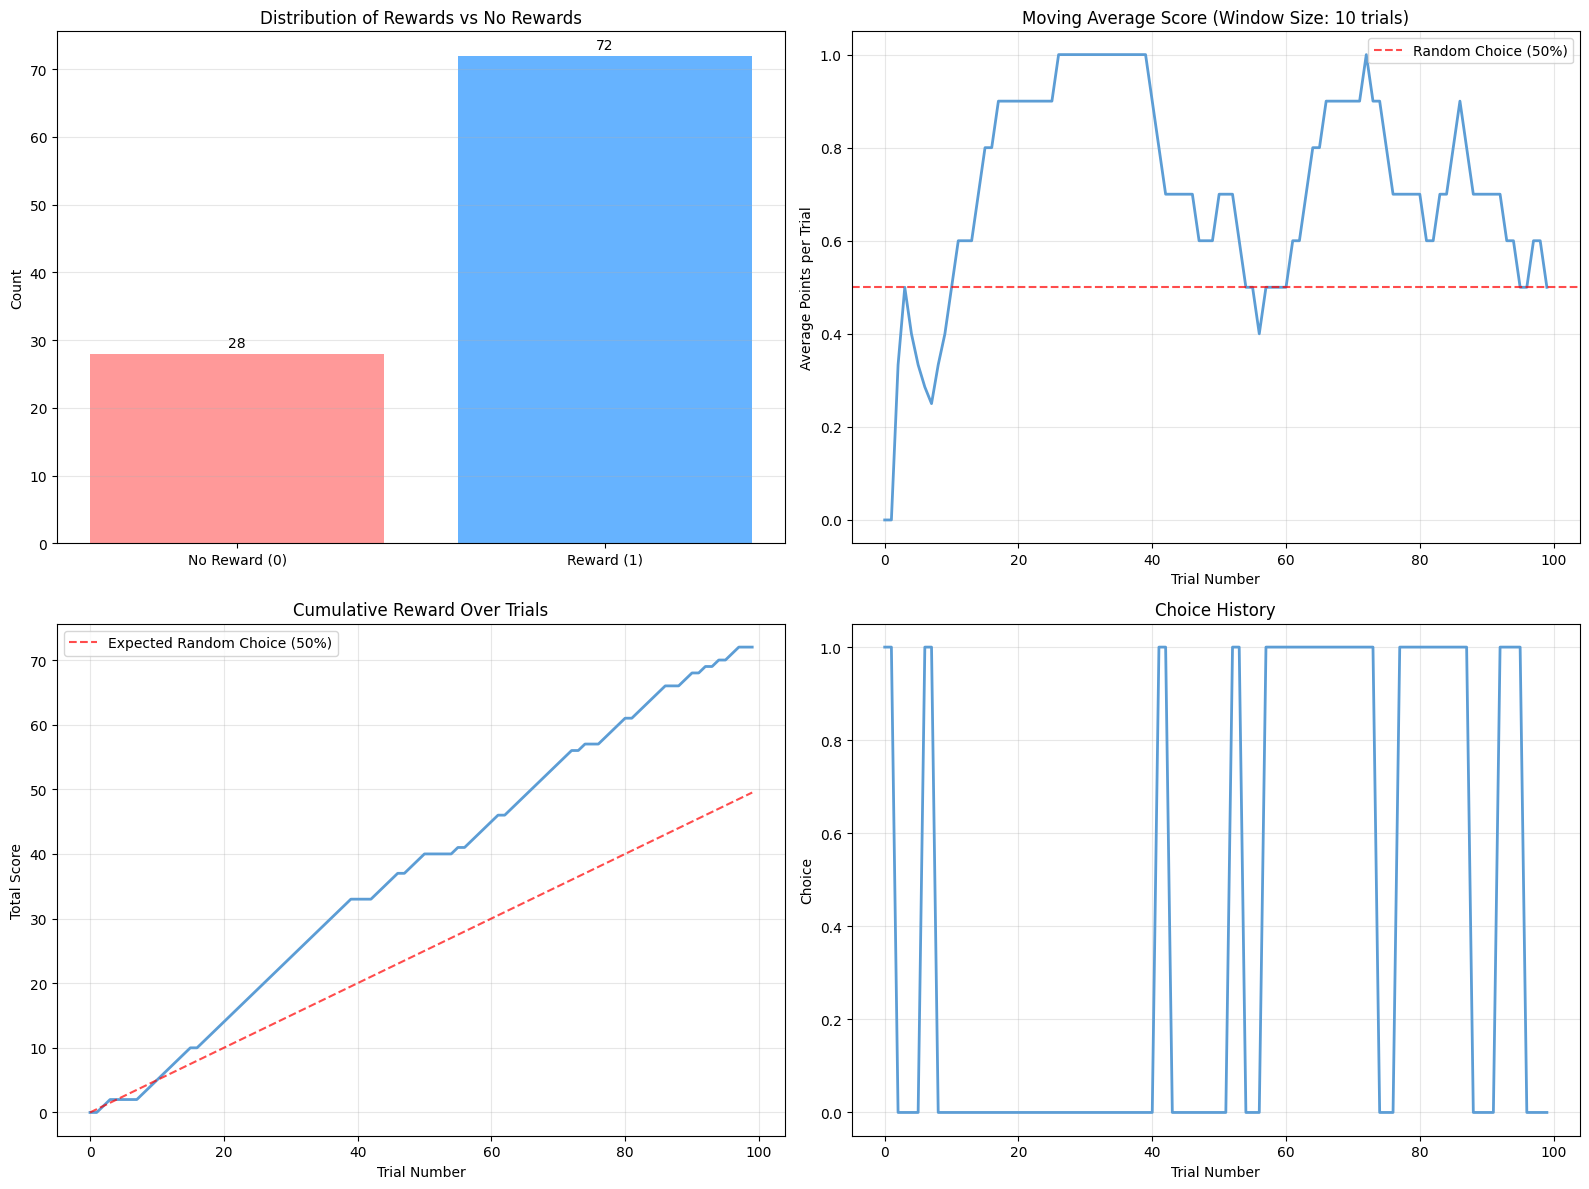

In [125]:
# rule based model
plot_all_metrics(df_rule_based, window_size=10)

## Parameter Fitting *(4 points)*

For this exercise you should:

*   Set up a suitable parameter search space *(1 point)*

*   Implement a procedure to evaluate the fit of a model based on data *(2 points)*

*   Implement a procedure for searching the parameter space. *(1 point)*

Make sure to comment your code and provide an explanation for each code block in a preceding text block.



In [126]:
# function to calculate the log likelihood of a model given the data
def log_likelihood(model, df):
    ll_sum = 0

    # repeat the simulation for each trial
    for i, row in df.iterrows():
        observed_action = row["action"]
        observed_reward = row["reward"]        

        # get action probability
        action_probability = model.get_action_probability(observed_action)
        
        # update the model as if the corection option was chosen
        # TODO check if this is the correct way
        model.update(observed_action, observed_reward)

        # if the action probability is 0, set it to a small number to avoid log(0)
        if action_probability <= 0:
            action_probability = 1e-10

        # update the log likelihood
        ll_sum += np.log(action_probability)
    return ll_sum


def grid_search(model_class, data, param_space):
    """
    Perform grid search to find the best parameters for a model.

    Parameters:
    -----------
    model_class : class
        The model class to instantiate (not an instance)
    data : list of dict
        The data to fit the model to
    param_space : dict
        Dictionary mapping parameter names to lists of values to search

    Returns:
    --------
    best_params : dict
        Dictionary of best parameters
    best_ll : float
        Log likelihood of the best model
    """
    best_ll = -np.inf
    best_params = {}
    param_names = list(param_space.keys())

    # Generate all parameter combinations
    param_combinations = []

    # TODO improve to only do nesscary parameter due to the exponentail natrue of grid search,
    # it takes a lot of time
        
    # This function recursivly generates all possible combinations of parameters
    def generate_combinations(current_combo, param_idx):
        # Base case: if we've reached the end of the parameter names list
        if param_idx == len(param_names):
            # Append a copy of the current combination to the list of combinations
            param_combinations.append(current_combo.copy())
            return

        # Get the current parameter name
        param_name = param_names[param_idx]
        # Iterate over all possible values for this parameter
        for param_value in param_space[param_name]:
            # Set the current parameter value in the current combination
            current_combo[param_name] = param_value
            # Recursively generate combinations for the next parameter
            generate_combinations(current_combo, param_idx + 1)

    

    generate_combinations({}, 0)

    # print("parameter combinations", param_combinations)
    
    # Evaluate each parameter combination
    for params in param_combinations:
        model = model_class(params)

        # Calculate log likelihood
        ll = log_likelihood(model, data)

        # Update best parameters if this is better
        if ll > best_ll:
            best_ll = ll
            best_params = params

    return best_params, best_ll

# calculate the BIC based on the log likelihood, the number of parameters and the number of samples
def calculate_bic(ll, n_params, n_samples):
    return np.round(-2 * ll + n_params * np.log(n_samples), 2)


# calculate the AIC based on the log likelihood, the number of parameters and the number of samples
def calculate_aic(ll, n_params, n_samples):
    return np.round(-2 * ll + 2 * n_params, 2)


## Parameter Recovery *(5 points)*

For this exercise you should:

*   Set up a suitable space of parameters relevant for parameter recovery *(1 point)*

*   Use the functions above to generate behavior from a models, for a given set of (randomly sampled) parameters, and then fit the model to its generated data. Make sure to evaluate the parameter fit in a quantiative manner. *(3 points)*

*   Plot the parameter recovery results for both models. *(1 point)*

Make sure to comment your code and provide an explanation for each code block in a preceding text block.





In [127]:
def plot_parameter_recovery(df_recovered, param_space):
    """
    Plot parameter recovery results showing original vs recovered parameters.

    Parameters:
    -----------
    df_recovered : pandas.DataFrame
        DataFrame containing original and recovered parameters
    param_space : dict
        Dictionary mapping parameter names to their search space
    """
    # Get the number of parameters to plot
    n_params = len(param_space.keys())

    # Create subplots
    fig, axes = plt.subplots(1, n_params, figsize=(5 * n_params, 5))

    # If only one parameter, make axes a list for consistent indexing
    if n_params == 1:
        axes = [axes]

    # Plot each parameter
    for i, param_name in enumerate(param_space.keys()):
        ax = axes[i]

        # Plot the recovered vs original values
        ax.scatter(
            df_recovered[f"original_{param_name}"],
            df_recovered[f"recovered_{param_name}"],
            alpha=0.7,
        )

        # Plot the ideal recovery line
        min_val = min(
            df_recovered[f"original_{param_name}"].min(),
            df_recovered[f"recovered_{param_name}"].min(),
        )
        max_val = max(
            df_recovered[f"original_{param_name}"].max(),
            df_recovered[f"recovered_{param_name}"].max(),
        )
        ax.plot([min_val, max_val], [min_val, max_val], "r--", alpha=0.5)

        # Add labels and title
        ax.set_xlabel(f"Original {param_name}")
        ax.set_ylabel(f"Recovered {param_name}")
        ax.set_title(f"Parameter Recovery: {param_name}")
        ax.grid(alpha=0.3)

    plt.tight_layout()
    plt.show()

def test_parameter_recovery(model_class, bandit_data, param_space, num_samples=10):
    results = []

    for i in range(num_samples):
        # choose random parameters for all param_space
        params = {}
        for param_name in param_space.keys():
            params[param_name] = np.random.choice(
                param_space[param_name]
            )

        df_logging = simulate_model(model_class, params, bandit_data)

        # fit the models to the data
        best_params, best_ll = grid_search(model_class, df_logging, param_space)
    
        # Create a result dictionary with unpacked parameters
        result = {}
        for param_name in param_space.keys():
            result[f"original_{param_name}"] = params[param_name]
            result[f"recovered_{param_name}"] = best_params[param_name]
        results.append(result)

    return pd.DataFrame(results)

# correlation between the original and recovered parameters
def print_parameter_recovery_correlations(df_recovered, model_name):
    """
    Print a clean correlation matrix focusing on original vs recovered parameters
    
    Parameters:
    -----------
    df_recovered : pandas.DataFrame
        DataFrame containing original and recovered parameters
    model_name : str
        Name of the model for display purposes
    """
    print(f"\n{model_name} Parameter Recovery Correlations:")
    
    # Get all parameter names (without the 'original_' or 'recovered_' prefix)
    param_names = set()
    for col in df_recovered.columns:
        if col.startswith('original_'):
            param_names.add(col.replace('original_', ''))
    
    # Print correlation between original and recovered for each parameter
    print("\nOriginal vs Recovered:")
    for param in param_names:
        corr = df_recovered[f'original_{param}'].corr(df_recovered[f'recovered_{param}'])
        print(f"  {param}: {corr:.3f}")
    
    # Print correlations between original parameters
    if len(param_names) > 1:
        print("\nCorrelations between original parameters:")
        orig_cols = [f'original_{param}' for param in param_names]
        orig_corr = df_recovered[orig_cols].corr()
        for i, param1 in enumerate(param_names):
            for param2 in list(param_names)[i+1:]:
                corr = orig_corr.loc[f'original_{param1}', f'original_{param2}']
                print(f"  {param1} vs {param2}: {corr:.3f}")
    
    # Print correlations between recovered parameters
    if len(param_names) > 1:
        print("\nCorrelations between recovered parameters:")
        recov_cols = [f'recovered_{param}' for param in param_names]
        recov_corr = df_recovered[recov_cols].corr()
        for i, param1 in enumerate(param_names):
            for param2 in list(param_names)[i+1:]:
                corr = recov_corr.loc[f'recovered_{param1}', f'recovered_{param2}']
                print(f"  {param1} vs {param2}: {corr:.3f}")
    
    print("\n" + "-"*50)


def create_param_space(range, num):
    return np.round(np.linspace(range[0], range[1], num), 2)

In [128]:
# set seed for reproducibility
np.random.seed(42)

num_samples = 10 # number of samples to test parameter recovery
param_samples = 3 # number of generate params for a parameter space

param_space = {
    "learning_rate": create_param_space([0, 1], param_samples),
    "beta": create_param_space([0.5, 5], param_samples),
    "curiosity": create_param_space([0, 1], param_samples),
    "loss_threshold": create_param_space([1,10], param_samples)
}

# generate surrogate data for the parameter recovery
bandit_data = generate_bandit_data()


### POSSIBLE IMPROVEMENTS ###
# -  reuse the parameter combiantions of gridsearch across trials and models. (because it takes a lot of time to compute)
# - only get the parameter combinations that are needed for the specifc model (no need to compute all combinations)



# test the parameter recovery
df_recovered_basic = test_parameter_recovery(
    BasicModel, bandit_data, param_space, num_samples=num_samples
)
print("basic Model param recovery", df_recovered_basic)

df_recovered_complex = test_parameter_recovery(
    ComplexModel, bandit_data, param_space, num_samples=num_samples
)
print("complex Model param recovery", df_recovered_complex)

df_recovered_rule_based = test_parameter_recovery(
    RuleBasedModel, bandit_data, param_space, num_samples=num_samples
)
print("rule based Model param recovery", df_recovered_rule_based)

basic Model param recovery    original_learning_rate  recovered_learning_rate  original_beta  \
0                     1.0                      1.0           0.50   
1                     0.0                      0.5           2.75   
2                     0.5                      1.0           0.50   
3                     0.0                      0.0           5.00   
4                     0.5                      0.5           5.00   
5                     0.0                      0.0           0.50   
6                     0.0                      0.5           2.75   
7                     1.0                      0.5           0.50   
8                     0.0                      0.0           5.00   
9                     0.5                      0.5           5.00   

   recovered_beta  original_curiosity  recovered_curiosity  \
0             0.5                 1.0                  0.0   
1             0.5                 0.0                  0.0   
2             0.5          


Basic Model Parameter Recovery Correlations:

Original vs Recovered:
  loss_threshold: nan
  curiosity: nan
  beta: 0.559
  learning_rate: 0.677

Correlations between original parameters:
  loss_threshold vs curiosity: -0.227
  loss_threshold vs beta: -0.135
  loss_threshold vs learning_rate: 0.570
  curiosity vs beta: -0.124
  curiosity vs learning_rate: 0.128
  beta vs learning_rate: -0.429

Correlations between recovered parameters:
  loss_threshold vs curiosity: nan
  loss_threshold vs beta: nan
  loss_threshold vs learning_rate: nan
  curiosity vs beta: nan
  curiosity vs learning_rate: nan
  beta vs learning_rate: 0.071

--------------------------------------------------

Complex Model Parameter Recovery Correlations:

Original vs Recovered:
  loss_threshold: nan
  curiosity: 0.535
  beta: 0.690
  learning_rate: 0.355

Correlations between original parameters:
  loss_threshold vs curiosity: 0.268
  loss_threshold vs beta: 0.399
  loss_threshold vs learning_rate: -0.088
  curiosi

/home/luca/Coding/uni/bandit-modeling/.venv/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/luca/Coding/uni/bandit-modeling/.venv/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/luca/Coding/uni/bandit-modeling/.venv/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/luca/Coding/uni/bandit-modeling/.venv/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/luca/Coding/uni/bandit-modeling/.venv/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/luca/Coding/uni/bandit-modeling/.venv/lib/python3.13/site-p

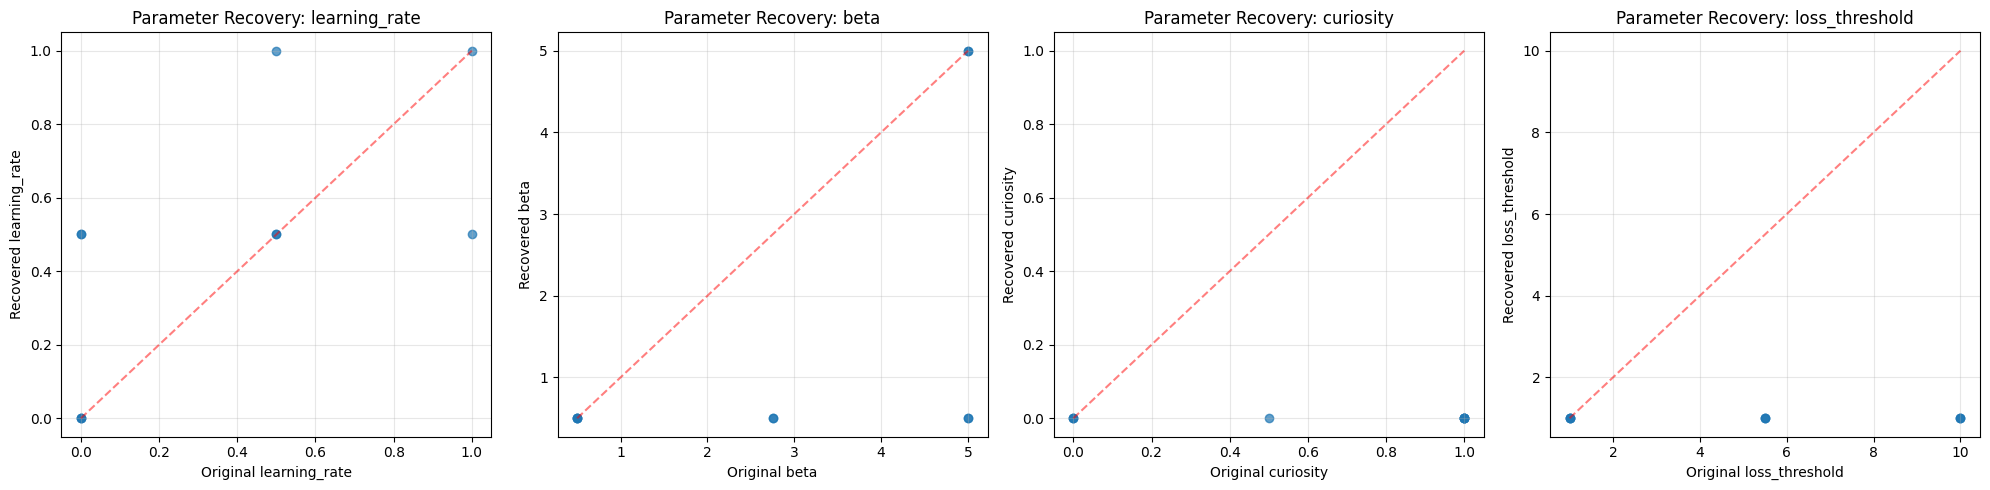

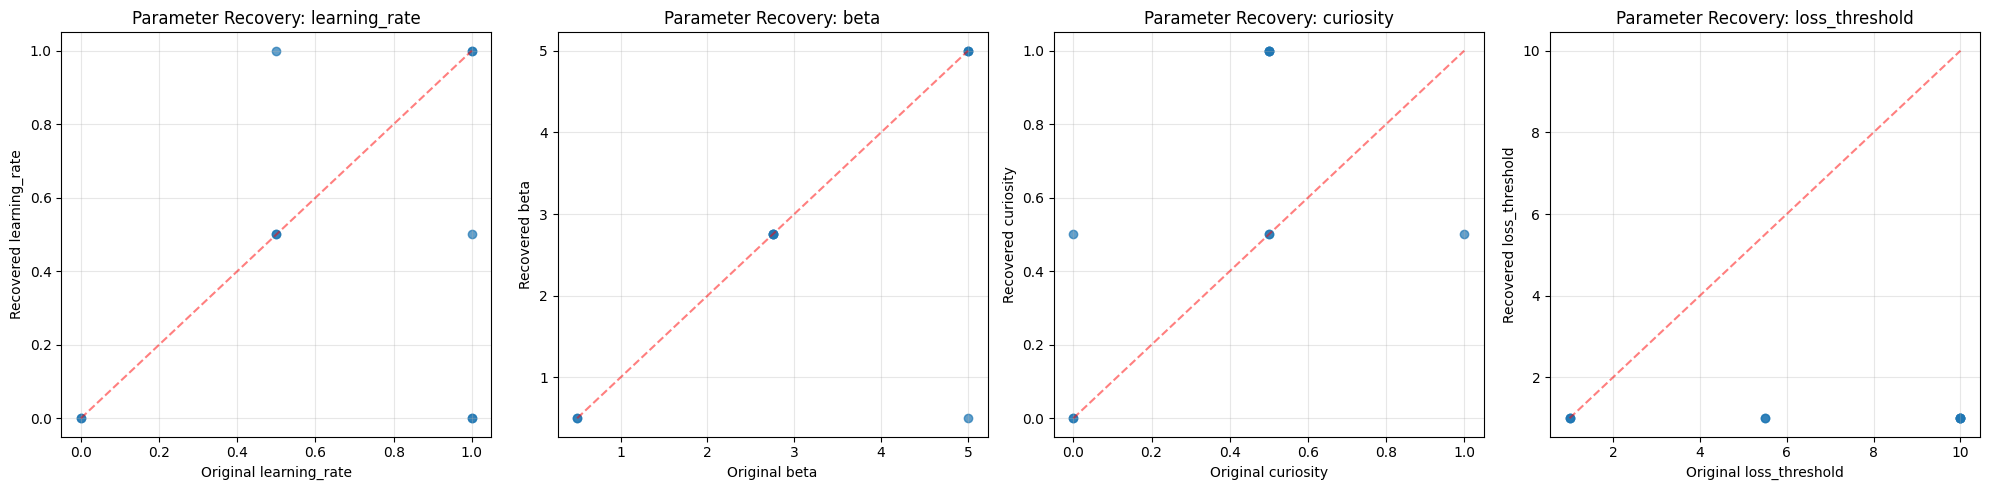

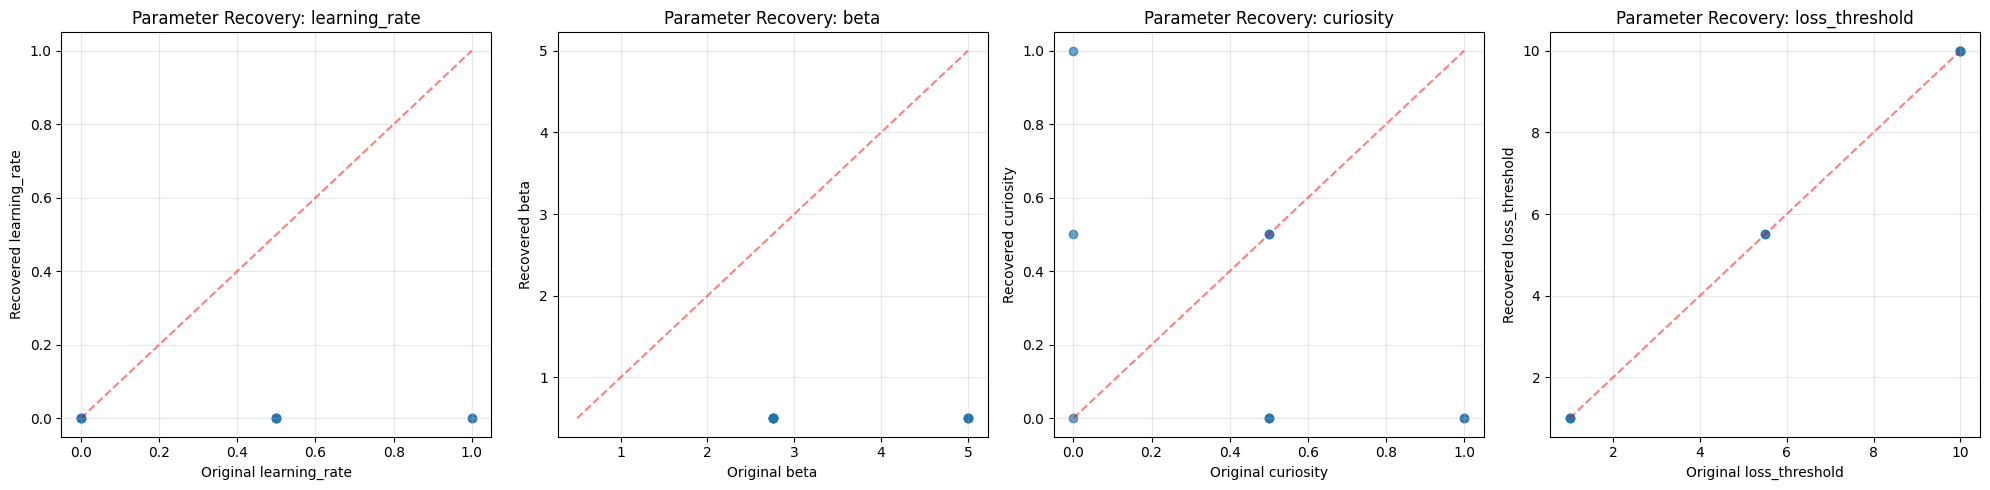

In [129]:
# Print the correlation information
print_parameter_recovery_correlations(df_recovered_basic, "Basic Model")
print_parameter_recovery_correlations(df_recovered_complex, "Complex Model")
print_parameter_recovery_correlations(df_recovered_rule_based, "Rule Based Model")

# plot the parameter recovery
plot_parameter_recovery(df_recovered_basic, param_space)
plot_parameter_recovery(df_recovered_complex, param_space)
plot_parameter_recovery(df_recovered_rule_based, param_space)

## *Optional*: Model Recovery *(2 bonus points)*

In this bonus exercise, you may examine model reovery. The bonus points count towards your total group project points. That is, you may accumlate up to 22 points in the practical part of the group project.

Make sure to comment your code and provide an explanation for each code block in a preceding text block.





In [139]:
def test_model_recovery(bandit_data, param_space, model_class):     
    # choose random parameters for the model
    params = {}
    for param_name in param_space.keys():
        params[param_name] = np.random.choice(param_space[param_name])
    
    # simulate the data
    surrogate_data = simulate_model(model_class, params, bandit_data)

    # fit all models to the data
    results = {}
    _, results["BasicModel"] = grid_search(BasicModel, surrogate_data, param_space)
    _, results["ComplexModel"] = grid_search(ComplexModel, surrogate_data, param_space)
    _, results["RuleBasedModel"] = grid_search(RuleBasedModel, surrogate_data, param_space)

    # return log likelihoods and best parameters for all models
    return results

def test_model_recovery_multiple(bandit_data, param_space, num_samples=5):
    df_results = pd.DataFrame(columns=["InputModel", "RecoveredModel"])
    
    # test the model recovery for all models
    model_classes = [BasicModel, ComplexModel, RuleBasedModel]
    for model_class in model_classes:
        for i in range(num_samples):
            # test the model recovery for this model and get log likelihoods and best parameters
            results = test_model_recovery(bandit_data, param_space, model_class)  
            
            print("results", results)         
            # get the most likely model, based on the log likelihood of each model
            most_likely_model_index = np.argmax([results["BasicModel"], results["ComplexModel"], results["RuleBasedModel"]])
            most_likely_model = model_classes[most_likely_model_index]
            new_row = pd.DataFrame([[model_class.__name__, most_likely_model.__name__]], columns=df_results.columns)
            df_results = pd.concat([df_results, new_row], ignore_index=True)
    return df_results

# Plot the model recovery results as a heatmap
def plot_model_recovery_heatmap(results_df):
    # Create a confusion matrix
    models = ['BasicModel', 'ComplexModel', 'RuleBasedModel']
    confusion_matrix = np.zeros((len(models), len(models)))
    
    # Count occurrences in each cell
    for i, input_model in enumerate(models):
        for j, recovered_model in enumerate(models):
            count = len(results_df[(results_df['InputModel'] == input_model) & 
                                  (results_df['RecoveredModel'] == recovered_model)])
            confusion_matrix[i, j] = count
    
    # Normalize by row (input model)
    row_sums = confusion_matrix.sum(axis=1, keepdims=True)
    confusion_matrix_norm = confusion_matrix / row_sums
    
    # Create the heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(confusion_matrix_norm, annot=True, fmt='.2f', cmap='Blues',
                xticklabels=models, yticklabels=models)
    plt.xlabel('Recovered Model')
    plt.ylabel('Input Model')
    plt.title('Model Recovery Confusion Matrix')
    plt.tight_layout()
    plt.show()
    
    # Print recovery accuracy
    diagonal_sum = np.trace(confusion_matrix)
    total_samples = confusion_matrix.sum()
    print(f"Overall recovery accuracy: {diagonal_sum}/{total_samples} = {diagonal_sum/total_samples:.2f}")


In [140]:
# set seed for reproducibility
np.random.seed(42)

# meta parameters
num_samples = 3 # number of samples to test model recovery
param_samples = 3 # number of generate params for a parameter space

# model parameter spaces
param_space = {
    "learning_rate": create_param_space([0, 1], param_samples),
    "beta": create_param_space([0.5, 5], param_samples),
    "curiosity": create_param_space([0, 1], param_samples),
    "loss_threshold": create_param_space([1,10], param_samples)
}

# generate surrogate data for the parameter recovery
bandit_data = generate_bandit_data()

results = test_model_recovery_multiple(bandit_data, param_space, num_samples=num_samples)

results

results {'BasicModel': np.float64(-66.0700321492277), 'ComplexModel': np.float64(-66.0700321492277), 'RuleBasedModel': np.float64(-1105.2408446371421)}
results {'BasicModel': np.float64(-65.6119072682957), 'ComplexModel': np.float64(-65.6119072682957), 'RuleBasedModel': np.float64(-967.0857390574996)}
results {'BasicModel': np.float64(-67.32259372026635), 'ComplexModel': np.float64(-67.32259372026635), 'RuleBasedModel': np.float64(-898.0081862676782)}
results {'BasicModel': np.float64(-21.38377848939067), 'ComplexModel': np.float64(-18.51876248275329), 'RuleBasedModel': np.float64(-713.8013788281544)}
results {'BasicModel': np.float64(-22.637353475178234), 'ComplexModel': np.float64(-13.437205950087025), 'RuleBasedModel': np.float64(-598.672124178452)}
results {'BasicModel': np.float64(-68.19887450578571), 'ComplexModel': np.float64(-67.97980430940588), 'RuleBasedModel': np.float64(-967.0857390574996)}
results {'BasicModel': np.float64(-21.950921643107414), 'ComplexModel': np.float64(-

,InputModel,RecoveredModel
0,BasicModel,BasicModel
1,BasicModel,BasicModel
2,BasicModel,BasicModel
3,ComplexModel,ComplexModel
4,ComplexModel,ComplexModel
5,ComplexModel,ComplexModel
6,RuleBasedModel,RuleBasedModel
7,RuleBasedModel,RuleBasedModel
8,RuleBasedModel,RuleBasedModel


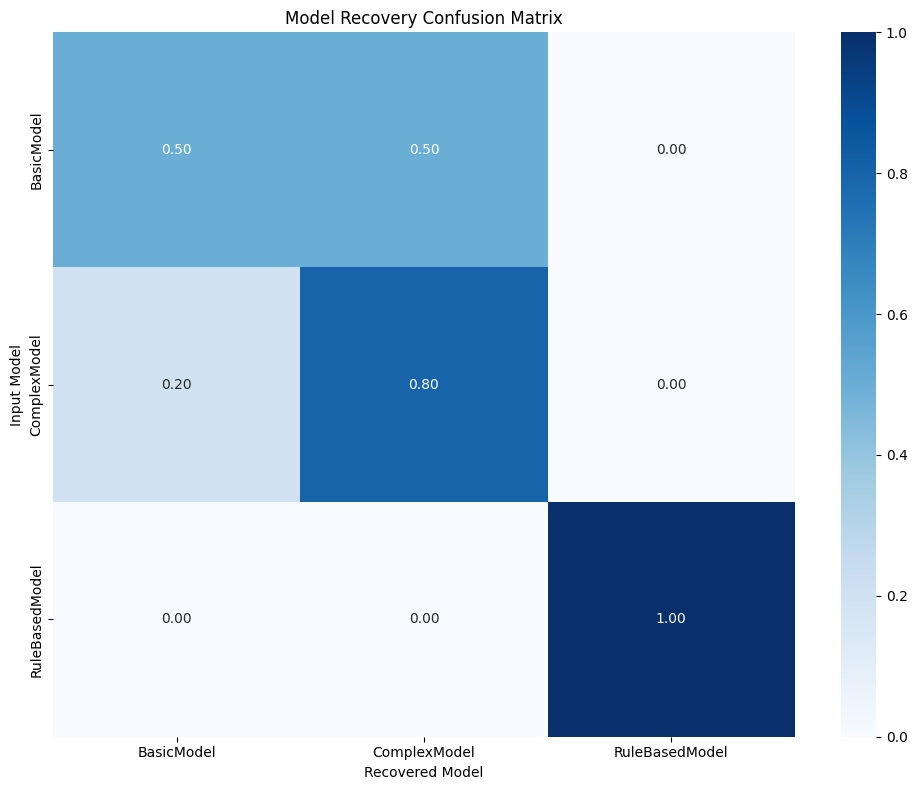

Overall recovery accuracy: 23.0/30.0 = 0.77


In [ ]:
plot_model_recovery_heatmap(results)

## Model Comparison *(5 points)*

For this exercise you should:

*   Load and (potentially) preprocess the experimental data. (1 point)

*   Fit the two models to the data.  *(1 point)*

*   Evaluate which model performs better, taking into account fit and model complexity. *(2 points)*

*   Plot the behavior of the winning model against the data. *(1 point)**

Make sure to comment your code and provide an explanation for each code block in a preceding text block.





In [ ]:
df_participant

In [ ]:
# fit the models
best_params_basic, best_ll_basic = grid_search(
    BasicModel, df_participant, param_space
)
best_params_complex, best_ll_complex = grid_search(
    ComplexModel, df_participant, param_space
)
best_params_rule_based, best_ll_rule_based = grid_search(
    RuleBasedModel, df_participant, param_space
)

model_names = ["BasicModel", "ComplexModel", "RuleBasedModel"]

print(f"Log Likelihood of Basic Model: {best_ll_basic}")
print(f"Log Likelihood of Complex Model: {best_ll_complex}")
print(f"Log Likelihood of Rule-Based Model: {best_ll_rule_based}")

print(f"BIC of Basic Model: {calculate_bic(best_ll_basic, len(best_params_basic), total_trials)}")
print(f"AIC of Basic Model: {calculate_aic(best_ll_basic, len(best_params_basic), total_trials)}")
print(f"BIC of Complex Model: {calculate_bic(best_ll_complex, len(best_params_complex), total_trials)}")
print(f"AIC of Complex Model: {calculate_aic(best_ll_complex, len(best_params_complex), total_trials)}")
print(f"BIC of Rule-Based Model: {calculate_bic(best_ll_rule_based, len(best_params_rule_based), total_trials)}")
print(f"AIC of Rule-Based Model: {calculate_aic(best_ll_rule_based, len(best_params_rule_based), total_trials)}")

best_model_name = model_names[np.argmax([best_ll_basic, best_ll_complex, best_ll_rule_based])]
print(f"Best model: {best_model_name}")

# Plot the behavior of the participant
print("\nParticipant Data:")
plot_all_metrics(df_participant, window_size=10, title="Participant Data")

# Create a new surrogate dataset with the same reward structure as the participant data
# Extract the reward structure from participant data
reward_structure = []
for i in range(len(df_participant)):
    reward_structure.append(df_participant['values'].iloc[i])

# Initialize the best model with the best parameters
best_model = None
if best_model_name == "BasicModel":
    best_model = BasicModel(
        learning_rate=best_params_basic["learning_rate"], 
        beta=best_params_basic["beta"]
    )
    print(f"\nBest Model (Basic) Parameters: Learning Rate = {best_params_basic['learning_rate']}, Beta = {best_params_basic['beta']}")
elif best_model_name == "ComplexModel":
    best_model = ComplexModel(
        learning_rate=best_params_complex["learning_rate"], 
        beta=best_params_complex["beta"], 
        curiosity=best_params_complex["curiosity"]
    )
    print(f"\nBest Model (Complex) Parameters: Learning Rate = {best_params_complex['learning_rate']}, Beta = {best_params_complex['beta']}, Curiosity = {best_params_complex['curiosity']}")
elif best_model_name == "RuleBasedModel":
    best_model = RuleBasedModel(
        loss_threshold=best_params_rule_based["loss_threshold"]
    )
    print(f"\nBest Model (Rule-Based) Parameters: Loss Threshold = {best_params_rule_based['loss_threshold']}")

# Initialize the dataframe for the best model simulation
df_best_model = pd.DataFrame(columns=["action", "reward", "values", "score", "q_values"])

# Simulate the best model's behavior on the same reward structure
for trial in range(len(reward_structure)):
    # Choose action based on the model
    if isinstance(best_model, RuleBasedModel):
        action = best_model.choose_action()
    else:
        action = best_model.choose_action()
    
    # Get reward based on the action and the reward structure
    reward = reward_structure[trial][action]
    
    # Update the model
    if isinstance(best_model, RuleBasedModel):
        best_model.update(reward)
        df_best_model = log_data(df_best_model, trial, action, reward, reward_structure[trial])
    else:
        best_model.update(action, reward)
        df_best_model = log_data(df_best_model, trial, action, reward, reward_structure[trial], best_model.get_q_values())

# Plot the behavior of the best model
print(f"\nBest Model ({best_model_name}) Simulation:")
plot_all_metrics(df_best_model, window_size=10, title=f"Best Model ({best_model_name}) Simulation")

# Compare model performance metrics
participant_score = df_participant['score'].iloc[-1]
model_score = df_best_model['score'].iloc[-1]

print(f"\nPerformance Comparison:")
print(f"Participant final score: {participant_score}")
print(f"Best model final score: {model_score}")
print(f"Score difference: {model_score - participant_score}")

In [ ]:
# After the existing code, add these comparison plots:

# Create comparison plots to directly visualize how well the model matches participant behavior
fig, axes = plt.subplots(2, 1, figsize=(12, 10))

# Plot 1: Compare choices over time
axes[0].plot(df_participant['action'], 'b-', label='Participant Choices', alpha=0.7)
axes[0].plot(df_best_model['action'], 'r--', label='Model Choices', alpha=0.7)
axes[0].set_title('Choice Comparison: Participant vs Model')
axes[0].set_xlabel('Trial Number')
axes[0].set_ylabel('Choice (0 or 1)')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Plot 2: Compare cumulative scores
axes[1].plot(df_participant['score'], 'b-', label='Participant Score', alpha=0.7)
axes[1].plot(df_best_model['score'], 'r--', label='Model Score', alpha=0.7)
axes[1].set_title('Cumulative Score Comparison: Participant vs Model')
axes[1].set_xlabel('Trial Number')
axes[1].set_ylabel('Cumulative Score')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Calculate and print choice match percentage
choice_matches = sum(df_participant['action'] == df_best_model['action'])
match_percentage = (choice_matches / len(df_participant)) * 100
print(f"\nChoice Match Analysis:")
print(f"Number of matching choices: {choice_matches} out of {len(df_participant)}")
print(f"Percentage of choices matched: {match_percentage:.2f}%")

# Calculate correlation between participant and model choices
# Fix: Convert to numpy arrays first and ensure they're numeric
try:
    participant_choices = np.array(df_participant['action']).astype(float)
    model_choices = np.array(df_best_model['action']).astype(float)
    choice_correlation = np.corrcoef(participant_choices, model_choices)[0, 1]
    print(f"Correlation between participant and model choices: {choice_correlation:.3f}")
except Exception as e:
    print(f"Could not calculate correlation: {e}")